In [79]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget


from pathlib import Path

import fiona
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape
from shapely.ops import transform
from sqlalchemy import create_engine

from ppcollapse.utils.config import ConfigManager
from ppcollapse.utils.database import get_image

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

shape_dir = Path("data/SHAPEFILES_adj")
file_ext = ".shp"

image_id = 32219

year = 2023
year_dir = shape_dir / f"{year}_qgis"

files = sorted(year_dir.glob(f"*{file_ext}"))

Image 32219 shape: (3456, 5184)
Reading data/SHAPEFILES_adj/2023_qgis/20230601.shp...


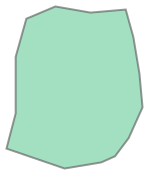

In [80]:
img = get_image(image_id=image_id, config=config)
print(f"Image {image_id} shape: {img.size}")

file = files[0]
print(f"Reading {file}...")

with fiona.open(file) as src:
    polygons = [feature["geometry"] for feature in src]

    # take the first polygon (shapefiles are all single-feature...)
    poly = polygons[0]

    # convert fiona geometry to shapely
    geom = shape(poly)

    # Invert y axis because the polygons were created in qgis
    geom = transform(lambda x, y, z=None: (x, -y) if z is None else (x, -y, z), geom)

geom

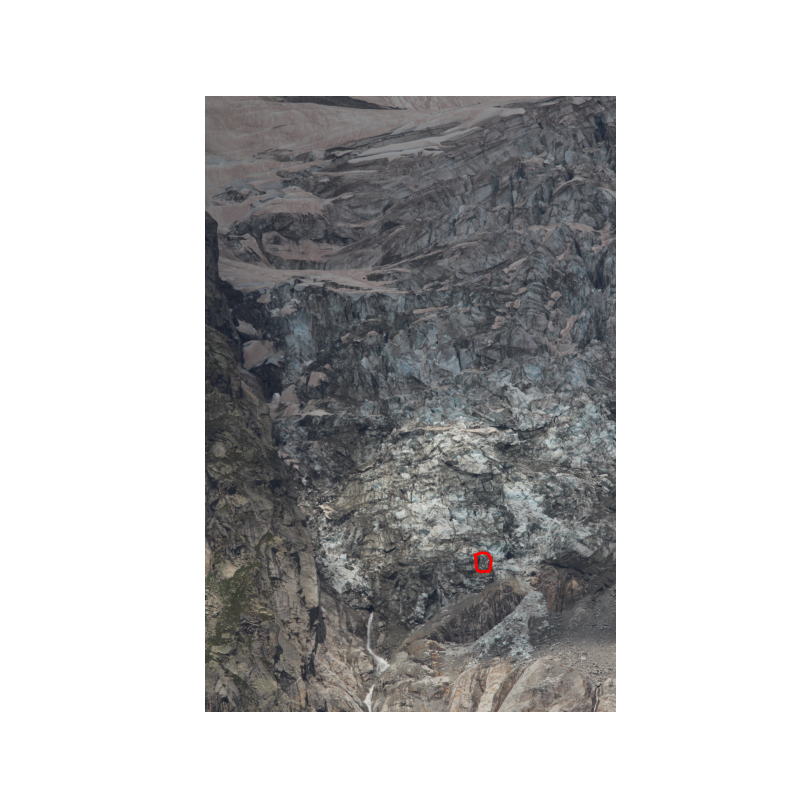

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
if geom.geom_type == "Polygon":
    geoms = [geom]
else:
    geoms = geom.geoms

for g in geoms:
    xs, ys = g.exterior.xy

    ax.fill(xs, ys, facecolor="none", edgecolor="red", linewidth=2)
ax.set_axis_off()
plt.show()
